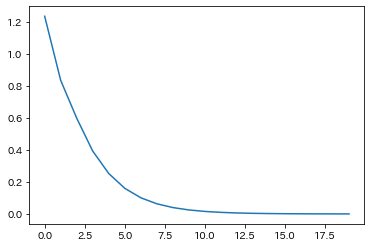

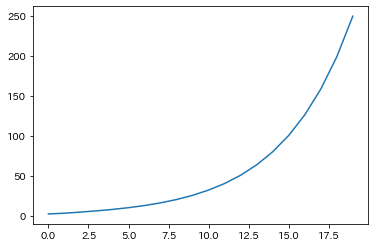

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

N = 2
H = 3
T = 20

def plot_gradients(weight = 0.5):
    fig = plt.figure()
    dh = np.ones((N, H))
    np.random.seed(3) 
    Wh = np.random.randn(H, H) * weight

    norm_list = []
    for t in range(T):
        dh = np.dot(dh, Wh.T)
        norm = np.sqrt(np.sum(dh**2)) / N
        norm_list.append(norm)

    plt.plot(norm_list)

    
plot_gradients(weight=0.5)
plot_gradients(weight=1.0)

In [13]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad += rate
         
print(dW1, dW2)
clip_grads(grads, max_norm)
print(dW1, dW2)

[[6.81611779 5.41019673 7.07180601]
 [2.63886671 9.26725684 8.39193058]
 [7.26319498 4.80239956 8.42103186]] [[7.44752323 6.60325906 9.13975267]
 [6.33665564 3.65940585 5.52844573]
 [1.96380577 1.92072296 7.25669624]]
[[6.99717048 5.59124942 7.2528587 ]
 [2.8199194  9.44830953 8.57298327]
 [7.44424767 4.98345225 8.60208455]] [[7.62857592 6.78431175 9.32080536]
 [6.51770833 3.84045854 5.70949842]
 [2.14485845 2.10177565 7.43774893]]


In [17]:
import sys
sys.path.append('..')
from common.functions import softmax, sigmoid

class LSTM(object):
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), 
                               np.zeros_like(Wh), 
                               np.zeros_like(b)]
        self.cache = None
        
    def forward(self, h, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


In [18]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None



In [19]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9996.55
| epoch 1 |  iter 21 / 1327 | time 4[s] | perplexity 3123.03
| epoch 1 |  iter 41 / 1327 | time 8[s] | perplexity 1198.24
| epoch 1 |  iter 61 / 1327 | time 11[s] | perplexity 931.33
| epoch 1 |  iter 81 / 1327 | time 16[s] | perplexity 790.69
| epoch 1 |  iter 101 / 1327 | time 20[s] | perplexity 654.89
| epoch 1 |  iter 121 / 1327 | time 24[s] | perplexity 641.41
| epoch 1 |  iter 141 / 1327 | time 28[s] | perplexity 597.39
| epoch 1 |  iter 161 / 1327 | time 32[s] | perplexity 573.65
| epoch 1 |  iter 181 / 1327 | time 36[s] | perplexity 588.69
| epoch 1 |  iter 201 / 1327 | time 40[s] | perplexity 502.11
| epoch 1 |  iter 221 / 1327 | time 44[s] | perplexity 502.28
| epoch 1 |  iter 241 / 1327 | time 48[s] | perplexity 435.48
| epoch 1 |  iter 261 / 1327 | time 52[s] | perplexity 468.64
| epoch 1 |  iter 281 / 1327 | time 56[s] | perplexity 457.93
| epoch 1 |  iter 301 / 1327 | time 60[s] | perplexity 393.11
| epoch 1

| epoch 2 |  iter 1261 / 1327 | time 532[s] | perplexity 121.39
| epoch 2 |  iter 1281 / 1327 | time 536[s] | perplexity 121.28
| epoch 2 |  iter 1301 / 1327 | time 540[s] | perplexity 154.82
| epoch 2 |  iter 1321 / 1327 | time 544[s] | perplexity 151.22
| epoch 3 |  iter 1 / 1327 | time 546[s] | perplexity 161.15
| epoch 3 |  iter 21 / 1327 | time 550[s] | perplexity 142.23
| epoch 3 |  iter 41 / 1327 | time 554[s] | perplexity 134.18
| epoch 3 |  iter 61 / 1327 | time 558[s] | perplexity 126.09
| epoch 3 |  iter 81 / 1327 | time 562[s] | perplexity 116.07
| epoch 3 |  iter 101 / 1327 | time 566[s] | perplexity 103.77
| epoch 3 |  iter 121 / 1327 | time 570[s] | perplexity 114.37
| epoch 3 |  iter 141 / 1327 | time 574[s] | perplexity 124.41
| epoch 3 |  iter 161 / 1327 | time 578[s] | perplexity 141.04
| epoch 3 |  iter 181 / 1327 | time 582[s] | perplexity 149.23
| epoch 3 |  iter 201 / 1327 | time 586[s] | perplexity 138.72
| epoch 3 |  iter 221 / 1327 | time 590[s] | perplexity 1

| epoch 4 |  iter 1181 / 1327 | time 1073[s] | perplexity 95.43
| epoch 4 |  iter 1201 / 1327 | time 1077[s] | perplexity 83.21
| epoch 4 |  iter 1221 / 1327 | time 1081[s] | perplexity 75.80
| epoch 4 |  iter 1241 / 1327 | time 1085[s] | perplexity 90.72
| epoch 4 |  iter 1261 / 1327 | time 1089[s] | perplexity 92.44
| epoch 4 |  iter 1281 / 1327 | time 1093[s] | perplexity 89.56
| epoch 4 |  iter 1301 / 1327 | time 1097[s] | perplexity 110.88
| epoch 4 |  iter 1321 / 1327 | time 1101[s] | perplexity 109.70


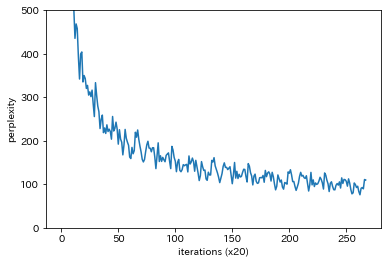

evaluating perplexity ...
234 / 235
test perplexity:  136.04377668113455


In [21]:
import sys
sys.path.append('..')
sys.path.append('../author_code/ch06')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 35  # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()


In [22]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTMレイヤを2層利用し、各層にDropoutを使うモデル
     [1]で提案されたモデルをベースとし、weight tying[2][3]を利用

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [23]:
import sys
sys.path.append('..')
from common import config
# GPUで実行する場合は下記のコメントアウトを消去（要cupy）
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)


Done
| epoch 1 |  iter 1 / 1327 | time 1[s] | perplexity 9999.62
| epoch 1 |  iter 21 / 1327 | time 34[s] | perplexity 3366.63
| epoch 1 |  iter 41 / 1327 | time 69[s] | perplexity 1741.39
| epoch 1 |  iter 61 / 1327 | time 103[s] | perplexity 1326.41


KeyboardInterrupt: 